# Set up a basic CNN to use for SSL later

In [2]:
# Imports

# Data Handling
import pandas as pd
import numpy as np
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor

# Efficient Loops
import itertools

# Traceback for Diagnosis
import traceback

# Data Visualization
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.io as pio
from IPython.display import display
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Statistics and Mathematics
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import shapiro, skew, anderson, kstest
import math

# Feature Selection
from sklearn.feature_selection import RFECV, SelectKBest, chi2, f_classif, f_regression, mutual_info_classif, mutual_info_regression

# Machine Learning Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin

# Preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, FunctionTransformer

# Model Selection
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RepeatedStratifiedKFold,  RepeatedKFold, TimeSeriesSplit

# Machine Learning Metrics
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,cohen_kappa_score,make_scorer,roc_curve,auc,accuracy_score,f1_score, precision_score,recall_score,confusion_matrix

# Machine Learning Regressors/Classifiers
from sklearn.linear_model import HuberRegressor, RANSACRegressor, TheilSenRegressor, Ridge, Lasso, ElasticNet, LogisticRegression, RidgeClassifier
from sklearn.svm import SVR, NuSVR, NuSVC, LinearSVR, LinearSVC
from sklearn.ensemble import HistGradientBoostingRegressor, StackingRegressor, AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.ensemble import HistGradientBoostingClassifier, StackingClassifier, AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier

# Clustering algorithms
from sklearn.cluster import KMeans

# Fine Tuning
import optuna

# Randomizer
import random

# Encoder
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# OS
import os

# File Handling
import pickle

# Image Package
from PIL import Image

# Hide Warnings
import warnings
warnings.filterwarnings('ignore')

In [26]:
# Import Keras (Tensorflow)
from keras.models import Sequential # Neural Network model as a sequence of layers
from keras.layers import Conv2D # Convolutional Layer
from keras.layers import MaxPooling2D # MaxPooling Layer
from keras.layers import Flatten # Layer used to flatten 2D arrays for fully connected layers
from keras.layers import Dense # Layer adds fully connected layers to the neural network
from keras.layers import Dropout # Layer used to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training time
from keras.layers import BatchNormalization # Layer used to normalize the activations of the neurons
from keras.layers import Activation # Layer used to apply an activation function to the output
from keras.callbacks import EarlyStopping, ModelCheckpoint # Classes used to save weights and stop training when improvements reach a limit
from keras.models import load_model # Function used to load a trained model
from keras.layers import Rescaling # Layer used to rescale the pixel values
from keras.optimizers import Adam, SGD # Optimizers used to train the model

import tensorflow as tf

## Set up the Notebook

In [4]:
# Configure Notebook
seed = 73
bg_color = "#EEF6FF"
paper_color = '#EEF6FF'

In [5]:
# Common Methods
def image_resizer(images):
    """
    This function resizes CIFAR-10 images to 32x32 pixels if they are not already in that size.
    """
    resized_images = []
    for img in images:
        if img.size != (32, 32):
            img = img.resize((32, 32), Image.ANTIALIAS)  # Resize non-32x32 images to 32x32
        resized_images.append(img)
    return resized_images

def plot_images_list(images, title, subtitle):
    """
    This function helps to plot a matric of images in a list
    """
    fig = sp.make_subplots(rows=3, cols=3)
    images = image_resizer(images)

    traces = []

    for i in range(min(9, len(images))):
        img = go.Image(z=np.array(images[i]))
        traces.append((img, i//3+1, i%3+1))

    fig.add_traces([trace[0] for trace in traces], rows=[trace[1] for trace in traces], cols=[trace[2] for trace in traces])
    fig.update_layout(
        title={'text': f'<b>{title} <br> <i><sub>{subtitle}</sub></i></b>', 'font': dict(size=22)},
        height=800,
        width=800,
        margin=dict(t=110, l=80),
        plot_bgcolor=bg_color, 
        paper_bgcolor=paper_color
    )

    fig.show()

In [6]:
# Use GPU if available
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
        print('\nGPU found! Using GPU...')
    except RuntimeError as e:
        print(e)
else:
    strategy = tf.distribute.get_strategy()
    print('Number of replicas: ', strategy.num_replicas_in_sync)

Number of replicas:  1


## Load and Explore the Data (EDA)

In [7]:
# Load data
data_dir = '../data/cifar-10-batches-py'

def load_cifar_batch(batch_filename):
    with open(batch_filename, 'rb') as f:
        batch = pickle.load(f, encoding='latin1')
    return batch


train_dir = [os.path.join(data_dir, f'data_batch_{i}') for i in range(1, 5)]
test_dir = os.path.join(data_dir, 'test_batch')
val_dir = os.path.join(data_dir, 'data_batch_5')

Exploration of the individual directory sizes and measure of degree of imbalance per class.

In [8]:
def count_class_distributions(data_batch):
    counts = np.zeros(10, dtype=int)
    for label in data_batch['labels']:
        counts[label] += 1
    return counts

def analyze_data(data_dir, dataset_name):
    print(f'Analyzing {dataset_name}')
    class_counts = np.zeros(10, dtype=int)
    for i, dir in enumerate(data_dir):
        data_batch = load_cifar_batch(dir)
        class_counts += count_class_distributions(data_batch)
    
    fig = go.Figure(
        data=[
            go.Bar(
                x=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'],
                y=class_counts)
            ]
        )
    
    fig.update_layout(
        title = f'Class Distribution of {dataset_name}',
        xaxis_title = 'Classes',
        yaxis_title = 'Count',
        xaxis_tickangle=-45,
    )

    fig.show()

analyze_data(train_dir, 'Training Data')
analyze_data([val_dir], 'Validation Data')
analyze_data([test_dir], 'Test Data')

Analyzing Training Data


Analyzing Validation Data


Analyzing Test Data


The largest imbalances are inside the validation set. As the balance is not perfect this may affect the outcome. 

CNNs require a fixed size for all images fed into it. 
The next check is for this requirement. If this condition is not met some sort of preprocessing will be necessary.

In [9]:
# Check image sizes
def check_image_sizes(data_dir, dataset_name):
    print(f'Checking {dataset_name}')
    
    size_count = defaultdict(int)

    for dir in data_dir:
        batch = load_cifar_batch(dir)
        images = batch['data'].reshape(-1, 3, 32, 32) #reshape to (num_images, channels, height, width)

        for image in images:
            image_size = tuple(image.shape[1:]) # Get the size of the image (height, width)
            size_count[image_size] += 1
    
    print(f'\n********** Image Sizes in {dataset_name} **********\n')
    for size, count in size_count.items():
        print(f'Image size {size} : {count}')

check_image_sizes(train_dir, 'Training Data')
check_image_sizes([val_dir], 'Validation Data')
check_image_sizes([test_dir], 'Test Data')

Checking Training Data

********** Image Sizes in Training Data **********

Image size (32, 32) : 40000
Checking Validation Data

********** Image Sizes in Validation Data **********

Image size (32, 32) : 10000
Checking Test Data

********** Image Sizes in Test Data **********

Image size (32, 32) : 10000


All images are of size 32x32 pixels.

Next some random images of each class are displayed to get a glimpse at the images of the dataset.

## Display random images

In [10]:
def select_random_images(data_dir, num_images_per_class):
    selected_images = {i: [] for i in range(10)} # 10 classes in CIFAR-10

    for dir in data_dir:
        batch = load_cifar_batch(dir)
        images = batch['data'].reshape(-1, 3, 32, 32) # Reshape to (num_images, channels, height, width)
        labels = batch['labels']

        for class_index in range(10):
            class_indices = [i for i, label in enumerate(labels) if label == class_index]
            random_indices = random.sample(class_indices, num_images_per_class)

            for idx in random_indices:
                selected_images[class_index].append(cifar_to_pil_image(images[idx]))
    
    return selected_images


def cifar_to_pil_image(image_array):
    image_array = np.transpose(image_array, (1, 2, 0)) # Reshape from (3, 32, 32) to (32, 32, 3)
    return Image.fromarray(image_array.astype('uint8'))


selected_images = select_random_images(train_dir, 3)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for class_index in range(10):
    class_name = class_names[class_index]
    plot_images_list(selected_images[class_index], title=f'Random Images from CIFAR-10 Class {class_name}', subtitle=f'Class {class_name}')

## Preprocessing

In [11]:
def save_images_to_directory(images, labels, directory, class_names):
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)
    
    for idx, (image, label) in enumerate(zip(images, labels)):
        class_name = class_names[label]
        image_path = os.path.join(directory, class_name, f'{idx}.png')
        tf.keras.preprocessing.image.save_img(image_path, image)

# Create Tensorflow Datasets
def prepare_data_directory(data_dir, save_dir, class_names):
    all_images = []
    all_labels = []

    for dir in data_dir:
        batch = load_cifar_batch(dir)
        imgs = batch['data'].reshape(-1, 3, 32, 32) # Reshape to (num_images, channels, height, width)
        imgs = np.transpose(imgs, (0, 2, 3, 1)) # Transpose to (num_images, height, width, channels)
        lbls = np.array(batch['labels'])

        all_images.append(imgs)
        all_labels.append(lbls)
    
    images = np.concatenate(all_images, axis=0)
    labels = np.concatenate(all_labels, axis=0)

    # Normalize pixel values
    images = images.astype('float32') / 255.0

    save_images_to_directory(images, labels, save_dir, class_names)

prepare_data_directory(train_dir, 'train_data_dir', class_names)
prepare_data_directory([val_dir], 'val_data_dir', class_names)
prepare_data_directory([test_dir], 'test_data_dir', class_names)

In [12]:
# Creating a Dataset for the Training Data
train = tf.keras.utils.image_dataset_from_directory(
    'train_data_dir', # the training data
    labels='inferred', # class labels are inferred from subdirectory names
    label_mode='categorical', 
    class_names=class_names,
    batch_size=16, # number of processed samples before updating the models weights
    image_size=(32, 32), # fixed dimensions for all images
    shuffle=True, 
    seed=seed, # random seed for shuffling and transformations
    validation_split=0, # no validation split as this is already done
    crop_to_aspect_ratio=True # resize images without aspect ratio distortion
)

Found 40000 files belonging to 10 classes.


In [13]:
# Creating a Dataset for the Training Data
test = tf.keras.utils.image_dataset_from_directory(
    'test_data_dir', # the training data
    labels='inferred', # class labels are inferred from subdirectory names
    label_mode='categorical', 
    class_names=class_names,
    batch_size=16, # number of processed samples before updating the models weights
    image_size=(32, 32), # fixed dimensions for all images
    shuffle=True, 
    seed=seed, # random seed for shuffling and transformations
    validation_split=0, # no validation split as this is already done
    crop_to_aspect_ratio=True # resize images without aspect ratio distortion
)

Found 10000 files belonging to 10 classes.


In [14]:
# Creating a Dataset for the Training Data
validation = tf.keras.utils.image_dataset_from_directory(
    'val_data_dir', # the training data
    labels='inferred', # class labels are inferred from subdirectory names
    label_mode='categorical', 
    class_names=class_names,
    batch_size=16, # number of processed samples before updating the models weights
    image_size=(32, 32), # fixed dimensions for all images
    shuffle=True, 
    seed=seed, # random seed for shuffling and transformations
    validation_split=0, # no validation split as this is already done
    crop_to_aspect_ratio=True # resize images without aspect ratio distortion
)

Found 10000 files belonging to 10 classes.


In [15]:
print(f'\nTraining Data: {train}')
print(f'\nTest Data: {test}')
print(f'\nValidation Data: {validation}')


Training Data: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

Test Data: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

Validation Data: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


In [16]:
# Confirm dataset is batched
for images, labels in train.take(1):
    print(f"Images batch shape: {images.shape}")
    print(f"Labels batch shape: {labels.shape}")

for images, labels in test.take(1):
    print(f"Images batch shape: {images.shape}")
    print(f"Labels batch shape: {labels.shape}")

for images, labels in validation.take(1):
    print(f"Images batch shape: {images.shape}")
    print(f"Labels batch shape: {labels.shape}")

Images batch shape: (16, 32, 32, 3)
Labels batch shape: (16, 10)
Images batch shape: (16, 32, 32, 3)
Labels batch shape: (16, 10)
Images batch shape: (16, 32, 32, 3)
Labels batch shape: (16, 10)


2024-06-30 18:49:21.290482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-30 18:49:21.310444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-30 18:49:21.330066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
# Check minimum and maximum pixel values
def check_min_max_pixel_values(dataset, dataset_name):
    min_value = float('inf')
    max_value = float('-inf')

    for image,_ in dataset:
        batch_min = tf.reduce_min(image)
        batch_max = tf.reduce_max(image)

        min_value = min(min_value, batch_min.numpy())
        max_value = max(max_value, batch_max.numpy())

    print(f'Minimum pixel value in {dataset_name}: {min_value}')
    print(f'Maximum pixel value in {dataset_name}: {max_value}')

check_min_max_pixel_values(train, 'Training')
check_min_max_pixel_values(test, 'Test')
check_min_max_pixel_values(validation, 'Validation')


2024-06-30 18:49:22.534668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Minimum pixel value in Training: 0
Maximum pixel value in Training: 255


2024-06-30 18:49:22.822614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Minimum pixel value in Test: 0
Maximum pixel value in Test: 255
Minimum pixel value in Validation: 0
Maximum pixel value in Validation: 255


2024-06-30 18:49:23.116118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Pixel values are not normalized to the range 0 to 1. 
This can be achieved by utilizing keras preprocessing rescaling.

In [18]:
scaler = Rescaling(1./255) # Rescale pixel values to [0, 1]

train = train.map(lambda x, y: (scaler(x), y))
test = test.map(lambda x, y: (scaler(x), y))
validation = validation.map(lambda x, y: (scaler(x), y))


check_min_max_pixel_values(train, 'Training')
check_min_max_pixel_values(test, 'Test')
check_min_max_pixel_values(validation, 'Validation')

2024-06-30 18:49:24.394169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Minimum pixel value in Training: 0.0
Maximum pixel value in Training: 1.0


2024-06-30 18:49:24.701994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Minimum pixel value in Test: 0.0
Maximum pixel value in Test: 1.0
Minimum pixel value in Validation: 0.0
Maximum pixel value in Validation: 1.0


2024-06-30 18:49:25.022901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Data Augmentation
Introducing diversity helps avoid overfitting.

Keras image augmentation layers are: 
• tf.keras.layers.RandomCrop: This layer randomly chooses a location to crop images down to a target size.

• tf.keras.layers.RandomFlip: This layer randomly flips images horizontally and or vertically based on the mode attribute.

• tf.keras.layers.RandomTranslation: This layer randomly applies translations to each image during training according to the fill_mode attribute.

• tf.keras.layers.RandomBrightness: This layer randomly increases/reduces the brightness for the input RGB images.

• tf.keras.layers.RandomRotation: This layer randomly rotates the images during training, and also fills empty spaces according to the fill_mode attribute.

• tf.keras.layers.RandomZoom: This layer randomly zooms in or out on each axis of each image independently during training.

• tf.keras.layers.RandomContrast: This layer randomly adjusts contrast by a random factor during training in or out on each axis of each image independently during training.


Here the augmentations RandomRotation, RandomContrast and RandomBrightness are applied

In [19]:
augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(
        factor=(-.25, .3), # rotate images by a random factor between -25% and 30%
        fill_mode='reflect', # fill in missing pixels with reflected pixels
        interpolation='bilinear', # use bilinear interpolation for rotating images
        seed=seed
    ),

    tf.keras.layers.RandomBrightness(
        factor=(-.45, .45), # adjust brightness by a random factor between -45% and 45%
        value_range=(0.1, 1.0), # adjust brightness between 10% and 100%
        seed=seed
    ),

    tf.keras.layers.RandomContrast(
        factor=(.5), # adjust contrast by a random factor between 50% and 150%
        seed=seed
    )
])

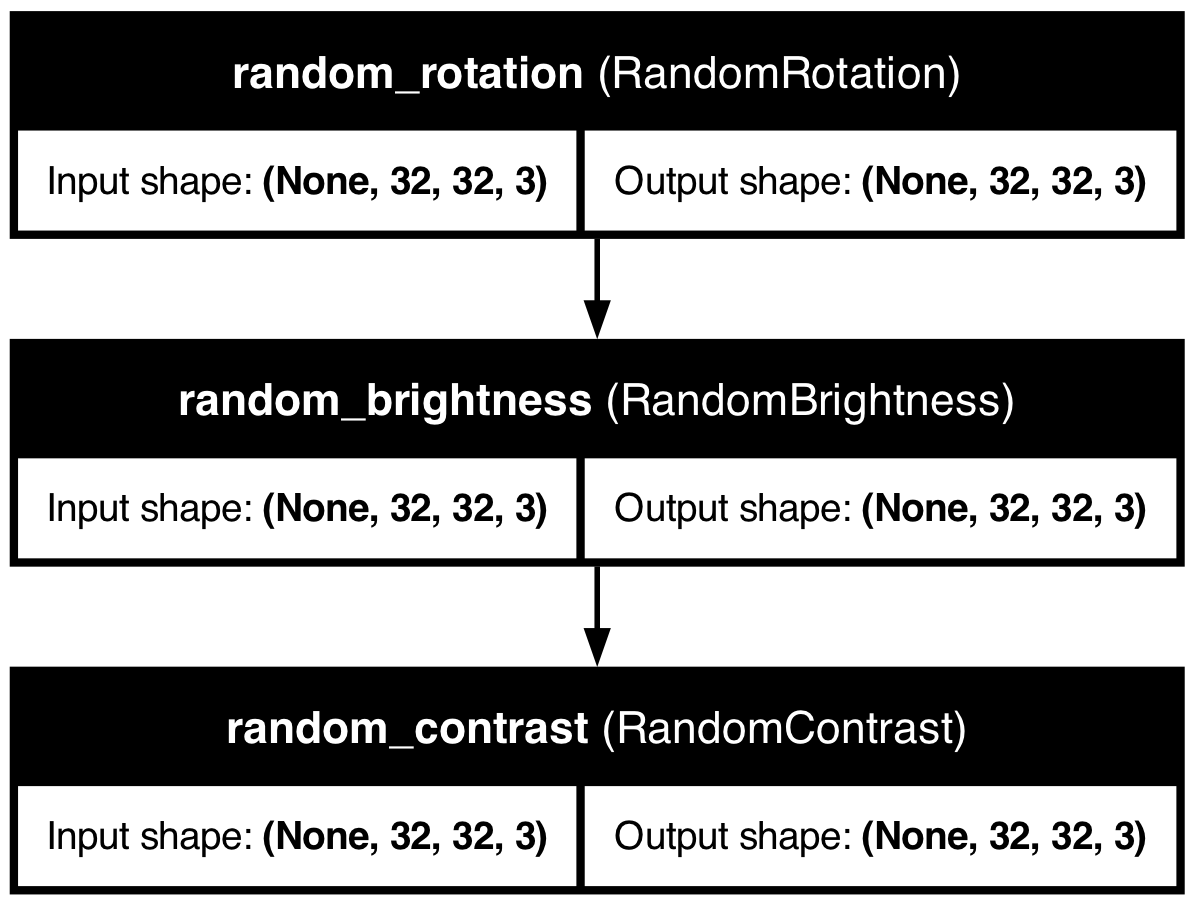

In [20]:
augmentation.build((None, 32, 32, 3)) # build the augmentation layer
tf.keras.utils.plot_model(augmentation, show_shapes=True, show_layer_names=True, expand_nested=True) # visualize the augmentation layer


## Building the CNN

### Layers: 

* Convolutional
The convolutional layer is the most important layer of a CNN; responsible for dealing with the major computations. The convolutional layer includes input data, a filter, and a feature map.
* Pooling
The pooling layer is responsible for reducing the dimensionality of the input. It also slides a filter across the entire input—without any weights—to populate the output array. We have two main types of pooling:
• Max Pooling: As the filter slides through the input, it selects the pixel with the highest value for the output array.
• Average Pooling: The value selected for the output is obtained by computing the average within the receptive field.
* Fully Connected
This is the layer responsible for performing the task classification based on the features extracted during the previous layers. While both convolutional and pooling layers tend to use ReLU functions, fully-connected layers use the Softmax activation function for classification, producing a probability from 0 to 1.
* BatchNormalization
This layer applies a transformation that maintains the mean output close to 0 and the standard deviation close to 1. It normalizes its inputs and is important to help convergence and generalization.
* Dropout
This layer randomly sets a fraction of input units to 0 during training, which helps to prevent overfitting.
* Flatten
This layer transforms a multi-dimensional tensor into a one-dimensional tensor. It is used when transitioning from the Feature Learning segment — Convolutional and Pooling layers — to the fully-connected layers.


The CNN will use different kernel sizes (3x3 and 5x5) to capture features at multiple scales.
Dropout rates will gradually increase as number of kernels increase.

In [27]:
# initiate model on GPU if available
with strategy.scope():
    model = Sequential()

    model.add(augmentation) # add the augmentation layer

    model.add(
        Conv2D(
            filters=32, # number of filters/kernels
            kernel_size=(3, 3), # size of kernels (3x3 matrix)
            activation='relu', # ReLU activation function
            kernel_initializer='he_uniform', # He initialization
            padding='same', # output feature map has same dimension as input
            input_shape=(32, 32, 3) # input shape of the first layer 32x32px with 3 color channels
        )
    )
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(
        MaxPooling2D(
            pool_size=(2, 2) # for each 2x2 pixel area, select the maximum value
        )
    )
    model.add(Dropout(0.2)) # randomly set 20% of the input units to 0 at each update during training time

    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten()) # flatten the 2D arrays for fully connected layers

    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform')) # add a fully connected layer with 2048 neurons
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax')) # add a fully connected layer with 10 neurons (one for each class)


Using keras compile to prepare NN for training. 

Parameters: 
* optimizer: In this parameter, we define the algorithms to adjust the weight updates. This is an important parameter, because choosing the right optimizer is essential to speed convergence. We are going to use RMSprop, which is the best optimizer I've found during the tests I ran.

* loss: This is the loss function we're trying to minimize during training. In this case, we are using categorical_crossentropy, which is a good choice for classification tasks with over two classes.

* metrics: This parameter defines the metric that will be used to evaluate performance during training and validation. Since our data is not heavily unbalanced, we may use accuracy for this, which is a very straightforward metric given by the following formula:

Accuracy = Number of Correct Predictions/Total Number of Predictions


In [30]:
opt = SGD(learning_rate=0.001, momentum=0.9) # Stochastic Gradient Descent optimizer with learning rate 0.001 and momentum 0.9

model.compile(
    optimizer = opt,
    loss = 'categorical_crossentropy', # Ideal for multi-class classification
    metrics = ['accuracy']
)

In [31]:
early_stopping = EarlyStopping(
    monitor='val_accuracy', # monitor the validation accuracy
    patience=5, # stop training after 5 epochs without improvement
    mode='max', # maximize the validation accuracy
    restore_best_weights=True # restore the best weights found during training
)

checkpoint = ModelCheckpoint(
    'best_model.keras', # file to save the best model
    monitor='val_accuracy', # monitor the validation accuracy
    save_best_only=True, # save only the best model
    mode='max' # maximize the validation accuracy
)

In [32]:
try:
    history = model.fit(
        train,
        epochs = 10, # number of epochs to train the model
        validation_data = test, # use the test data to evaluate the model
        callbacks = [early_stopping, checkpoint] # use early stopping and checkpointing
    )
except Exception as e:
    print(f'An error occurred: {e}')
    traceback.print_exc()

Epoch 1/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 89s 35ms/step - accuracy: 0.1641 - loss: 2.3455 - val_accuracy: 0.2814 - val_loss: 1.9447
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 91s 36ms/step - accuracy: 0.2338 - loss: 2.0311 - val_accuracy: 0.3502 - val_loss: 1.7183
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 92s 37ms/step - accuracy: 0.2744 - loss: 1.9494 - val_accuracy: 0.3820 - val_loss: 1.6462
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 89s 36ms/step - accuracy: 0.3012 - loss: 1.8834 - val_accuracy: 0.3903 - val_loss: 1.6158
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 95s 38ms/step - accuracy: 0.3289 - loss: 1.8288 - val_accuracy: 0.4092 - val_loss: 1.6054
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 91s 36ms/step - accuracy: 0.3487 - loss: 1.7717 - val_accuracy: 0.4127 - val_loss: 1.5806
Epoch 7/10
1107/2500 ━━━━━━━━━━━━━━━━━━━━ 47s 34ms/step - accuracy: 0.3648 - loss: 1.7265

KeyboardInterrupt: 